In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import read_data as rd  # Importing the read_data.py module
from scipy.fft import fft
from scipy.stats import skew, kurtosis
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Function to normalize the data using min-max scaling
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

def extract_time_domain_features(signal):
    features = []
    for i in range(signal.shape[1]):
        sig = signal[:, i]
        features.extend([
            np.mean(sig),               # Mean
            np.std(sig),                # Standard Deviation
            skew(sig),                  # Skewness
            kurtosis(sig),              # Kurtosis
            np.max(sig),                # Maximum
            np.min(sig),                # Minimum
            np.ptp(sig),                # Peak-to-Peak
            np.sqrt(np.mean(sig**2)),   # RMS
            np.sum(np.abs(np.diff(np.sign(sig)))) / 2,  # Zero Crossing Rate
            np.sum(sig**2)              # Energy
        ])
    return features

def extract_fft_features(signal, fs, top_n=50):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[:N//2])
    
    # Get indices of the top_n highest frequencies
    top_indices = np.argsort(yf)[-top_n:]
    
    # Extract the top_n highest FFT features
    fft_features = yf[top_indices]
    return fft_features

def extract_frequency_domain_features(signal, fs):
    features = []
    for i in range(signal.shape[1]):
        sig = signal[:, i]
        freqs, psd = welch(sig, fs)
        
        features.extend([
            np.mean(psd),                   # Mean Power Spectral Density
            np.sum(psd),                    # Total Power
            np.argmax(psd),                 # Peak Frequency
            np.mean(freqs * psd) / np.mean(psd),  # Spectral Centroid
            np.sqrt(np.mean((freqs - np.mean(freqs))**2 * psd)) / np.mean(psd),  # Spectral Bandwidth
            np.percentile(psd, 75) - np.percentile(psd, 25),  # Spectral Contrast
            np.max(freqs[np.cumsum(psd) / np.sum(psd) <= 0.85])  # Spectral Roll-off
        ])
        
    return features

In [3]:
# Load data
dataset_dir = '/home/ecappiell/datasets/full'
data_arrays, labels, class_ids = rd.process_mafaulda_data(dataset_dir)

In [4]:
# Original sampling rate (in Hz)
original_sampling_rate = 50 * 10**3  # 50 kHz

# Target sampling rate (in Hz)
target_sampling_rate = 2 * 10**3  # 2 kHz

# Downsample the data
downsampled_data = rd.downsample_data(data_arrays, original_sampling_rate, target_sampling_rate)

In [5]:
# Normalize the downsampled d ata
normalized_data = np.array([normalize_data(signal) for signal in downsampled_data])

In [6]:
# Extract features for each signal
X = []
for signal in normalized_data:
    time_features = extract_time_domain_features(signal)
    fft_features = [extract_fft_features(signal[:, i], target_sampling_rate) for i in range(signal.shape[1])]
    freq_features = extract_frequency_domain_features(signal, target_sampling_rate)
    signal_features = np.concatenate((time_features, np.hstack(fft_features), freq_features))
    X.append(signal_features)
X = np.array(X)

In [7]:
# Assuming labels and class_ids are prepared for classification
y = np.array(class_ids)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
# Normalize the feature matrix using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [21]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [22]:
# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training the model
num_epochs = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_correct = 0
    epoch_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        epoch_total += y_batch.size(0)
        epoch_correct += (predicted == y_batch).sum().item()

    train_loss = epoch_loss / len(train_loader)
    train_accuracy = epoch_correct / epoch_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
        
        _, val_predicted = torch.max(val_outputs.data, 1)
        val_accuracy = (val_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        val_accuracies.append(val_accuracy)

    model.train()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/25, Train Loss: 0.6989, Train Accuracy: 0.7612, Val Loss: 0.2728, Val Accuracy: 0.9096
Epoch 2/25, Train Loss: 0.2911, Train Accuracy: 0.9077, Val Loss: 0.1628, Val Accuracy: 0.9505
Epoch 3/25, Train Loss: 0.2224, Train Accuracy: 0.9253, Val Loss: 0.2623, Val Accuracy: 0.9283
Epoch 4/25, Train Loss: 0.2145, Train Accuracy: 0.9282, Val Loss: 0.3118, Val Accuracy: 0.9010
Epoch 5/25, Train Loss: 0.1352, Train Accuracy: 0.9582, Val Loss: 0.1242, Val Accuracy: 0.9556
Epoch 6/25, Train Loss: 0.1562, Train Accuracy: 0.9553, Val Loss: 0.1750, Val Accuracy: 0.9454
Epoch 7/25, Train Loss: 0.1044, Train Accuracy: 0.9619, Val Loss: 0.1228, Val Accuracy: 0.9693
Epoch 8/25, Train Loss: 0.1033, Train Accuracy: 0.9670, Val Loss: 0.1302, Val Accuracy: 0.9710
Epoch 9/25, Train Loss: 0.1158, Train Accuracy: 0.9722, Val Loss: 0.1463, Val Accuracy: 0.9573
Epoch 10/25, Train Loss: 0.0553, Train Accuracy: 0.9824, Val Loss: 0.1456, Val Accuracy: 0.9625
Epoch 11/25, Train Loss: 0.0785, Train Accuracy: 

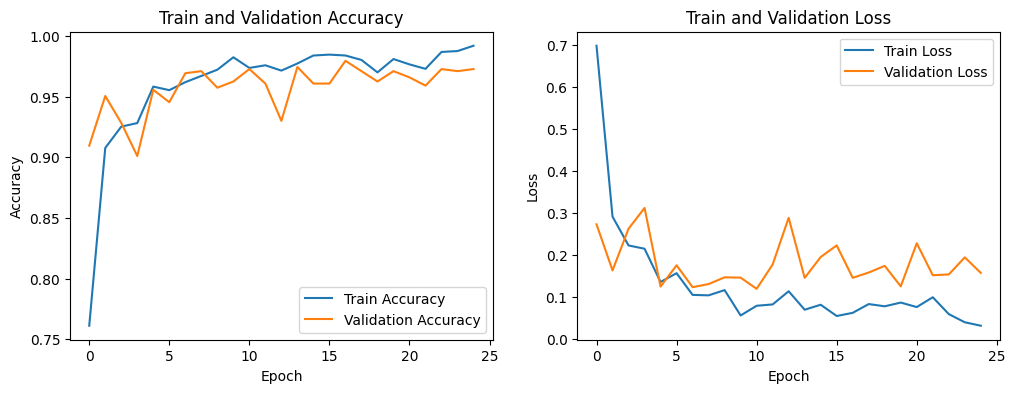

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Loss')

plt.show()

In [25]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1).numpy()

In [26]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9727
Precision: 0.9731
Recall: 0.9727
F1 Score: 0.9727


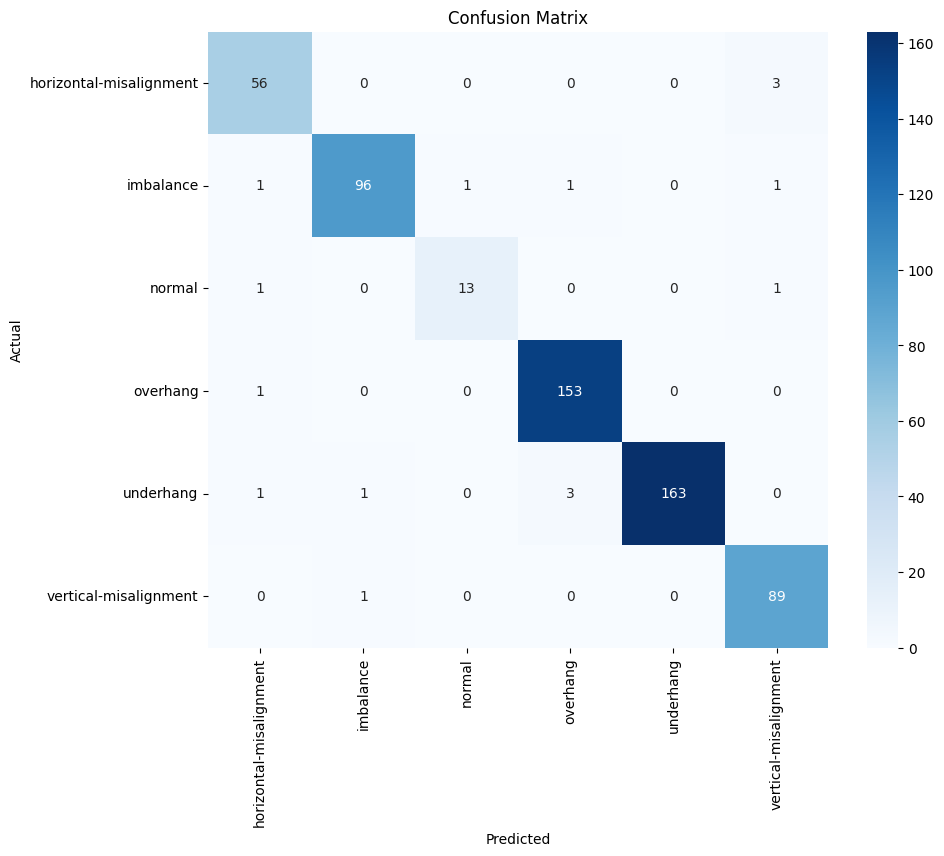

In [27]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()